# Preliminary EDA for eICU Data

### Goals:
* Identify relevant variables 
* Explore potential transformations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('./raw_agg_patient_table.csv')

<BarContainer object of 15 artists>

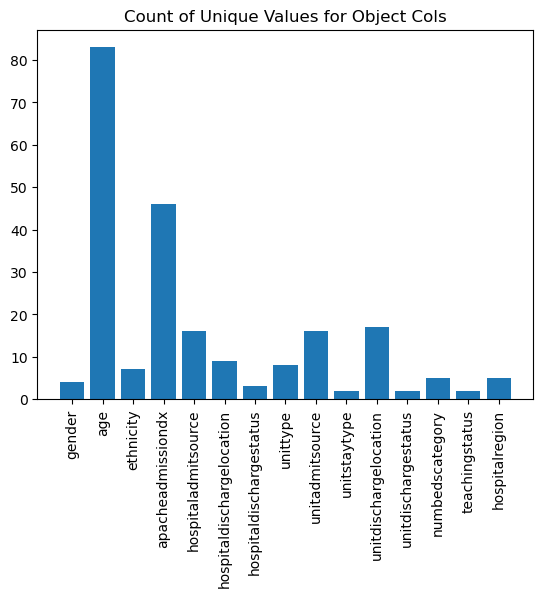

In [3]:
cols = data.columns

# _ = [print(col, data[col].dtypes) for col in cols]

unique_vals = {col:pd.unique(data[col]) for col in cols}

drop_cols = ['uniquepid',
          'hospitaladmittime24',
          'hospitaldischargetime24',
          'unitadmittime24',
          'unitdischargetime24',
         ]

obj_vars = [key for key, val in unique_vals.items() if val.dtype == object and key not in drop_cols]

counts = list(len(unique_vals[name]) for name in obj_vars)
obj_vars
counts

plt.figure()
plt.xticks(rotation = 90)
plt.title("Count of Unique Values for Object Cols")
plt.bar(obj_vars, counts)

In [4]:
time_vars = [col for col in cols if "time" in col]
id_vars = [col for col in cols if "id" in col]

# Straggler 'id' columns
id_vars.remove('aids')
id_vars.remove('meanvolumeoffluid')


time_vars, id_vars, obj_vars


# Just using to make a set difference, Time, ID, Object
tio_vars = time_vars + id_vars + obj_vars

other_vars = [col for col in cols if col not in tio_vars]
other_vars
# _ = [print(col, data[col].dtypes) for col in other_vars]

# Cleanup:
# Seems that any cols with 'dischargestatus', 'dischargelocation' are going to be variables that cause data leakage (other than predictor)
obj_vars = [o for o in obj_vars if 'dischargelocation' not in o and 'dischargestatus' not in o]

# But we want to keep this one 
obj_vars +=  ['dischargestatus']


### Categorical Data Analysis

For all variables that are categorical/discrete, we want to check for balance across both classification outcomes. Additionally, some transforms may be more or less appropriate

In [13]:
for o in obj_vars:
    if o == 'age':
        data[o] = pd.Categorical(data[o])

# _ = [print(col, data[col].dtypes) for col in obj_vars]


plot_vars = ['gender',
 'ethnicity',
 'hospitaladmitsource',
 'unittype',
 'unitstaytype',
 'numbedscategory',
 'teachingstatus',
 'hospitalregion',
 'dischargestatus']

data[plot_vars]

# initial thoughts -- relatively well balanced across gender, ethnicity
# Most deaths are coming from the south, 
# 1/7 mortality vs. 1/8 from teaching vs. full time1

# (pd.pivot_table(data[plot_vars], index = "gender", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
# (pd.pivot_table(data[plot_vars], index = "ethnicity", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
(pd.pivot_table(data[plot_vars], index = "hospitaladmitsource", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
(pd.pivot_table(data[plot_vars], index = "teachingstatus", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
# (pd.pivot_table(data[plot_vars], index = "hospitalregion", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')

### Numerical Data Analysis

Generally seek to confirm of (approximate) multivariate normal for variable selection/etc; may not be relevant for more ml techniques like lasso

Without domain specific knowledge, difficult to say about the data integrity for some of the variables; however, for admission weight, height, I think it unlikely that someone is 600 cm tall and another patient weights 340 KG (750 lb) when admitted and was discharged at 370 KG!

Other Notes:

* PH should have a max of 14
* What does icuduration represent?
* Supposed binary Values:
* - Intubated
* - vent
* - aids
* - lymphoma
* - immunosuppression



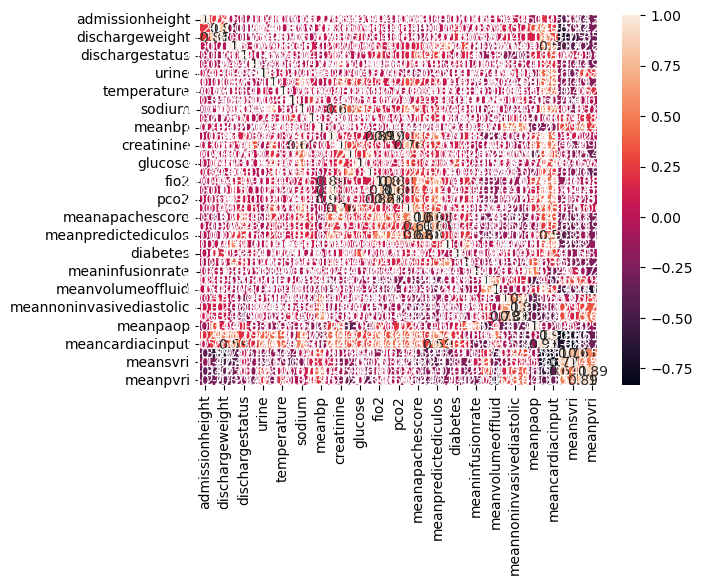

In [11]:
import seaborn as sns


binaries = ['intubated', 'vent', 'aids', 'lymphoma', 'immunosuppression']
plot_vars = [var for var in other_vars if var not in binaries]

numeric = data[plot_vars]
 

# for o in other_vars:
#     print(data[o].describe())

ax = sns.heatmap(numeric.corr(), annot=True)


In [15]:
data

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,meannoninvasivesystolic,meannoninvasivediastolic,noninvasivemeanavg,meanpaop,meancardiacoutput,meancardiacinput,meansvr,meansvri,meanpvr,meanpvri
0,141203,128948,Female,77,Caucasian,66,90,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,...,103.371069,57.333333,74.356250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141276,129009,Female,59,Caucasian,63,95,"Arrest, respiratory (without cardiac arrest)",165.1,14:43:00,...,138.500000,71.875000,97.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,141337,129059,Female,72,Hispanic,71,113,Thoracotomy for other reasons,154.9,20:27:12,...,122.411765,61.588235,85.294118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,141436,129143,Male,46,Hispanic,73,92,"Arrest, respiratory (without cardiac arrest)",167.6,04:13:00,...,118.750000,69.875000,86.075000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,141596,129269,Male,68,Caucasian,63,95,Thoracotomy for lung cancer,172.7,19:18:58,...,150.952381,69.015873,98.841270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17162,3352737,2742637,Male,70,African American,458,1106,"Arrest, respiratory (without cardiac arrest)",182.9,13:52:00,...,116.608247,62.711340,83.340206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17163,3352956,2742837,Male,59,Caucasian,458,1104,"Embolus, pulmonary",178.0,07:43:00,...,122.013699,76.684932,93.739726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17164,3353127,2742991,Male,59,Caucasian,458,1104,"Hypertension-pulmonary, primary/idiopathic",165.1,02:17:00,...,112.360000,72.760000,87.520000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17165,3353237,2743086,Female,79,Caucasian,458,1106,"Embolus, pulmonary",162.6,01:45:00,...,137.173913,78.869565,102.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Generic PCA for variable selection

In [37]:
scaler = StandardScaler()

numeric = numeric.fillna(0)

numeric_scaled = scaler.fit_transform(numeric)

pca = PCA(n_components = 10).fit(numeric_scaled)

numeric_pca = pca.fit(numeric_scaled)

covmat = pca.get_covariance()

# plt.plot(covmat)

# numeric_pca.feature_names_in_



/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_3155/778892784.py:17: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_3155/778892784.py:19: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_3155/778892784.py:21: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])


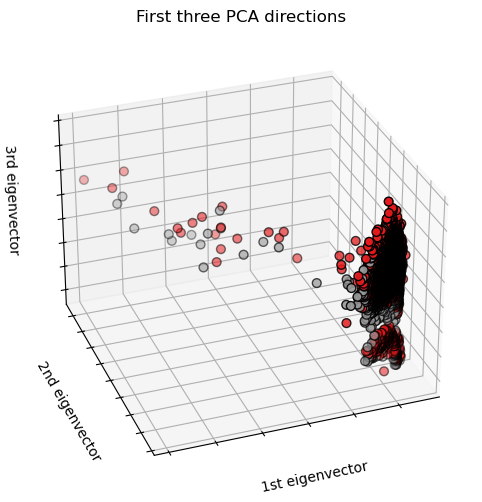

In [38]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = pca.fit_transform(numeric_scaled)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=data['dischargestatus'],
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

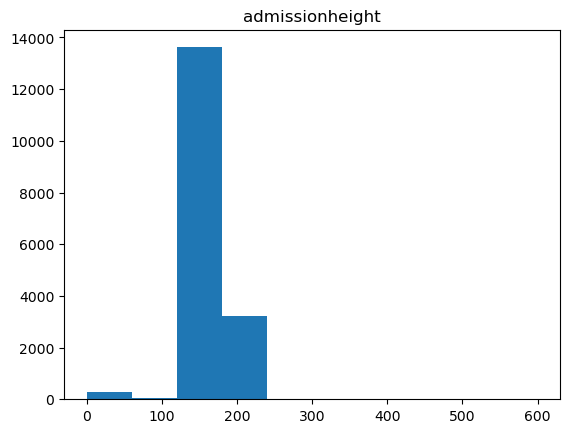

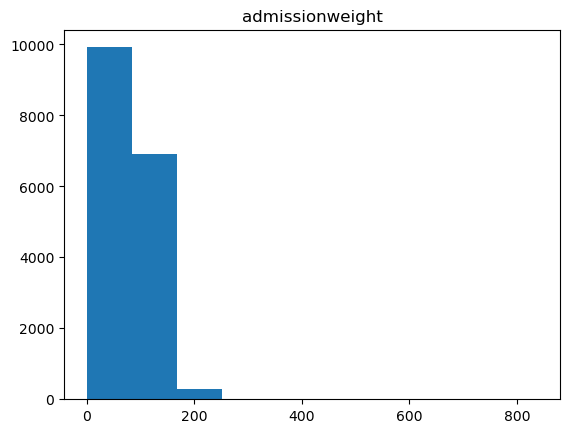

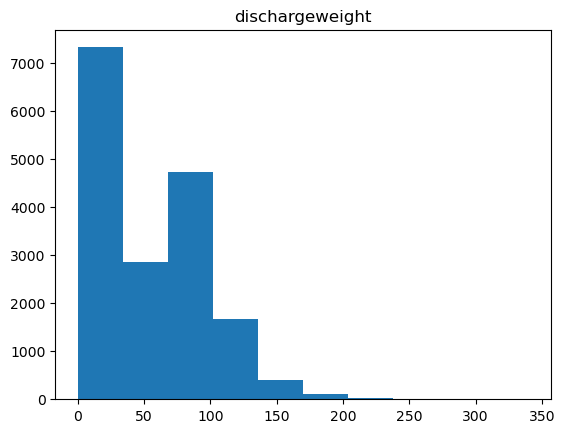

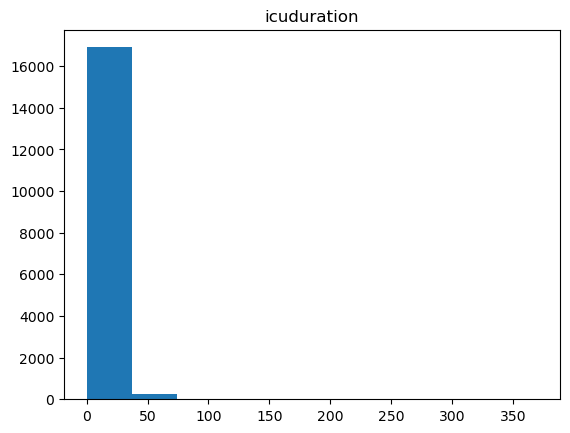

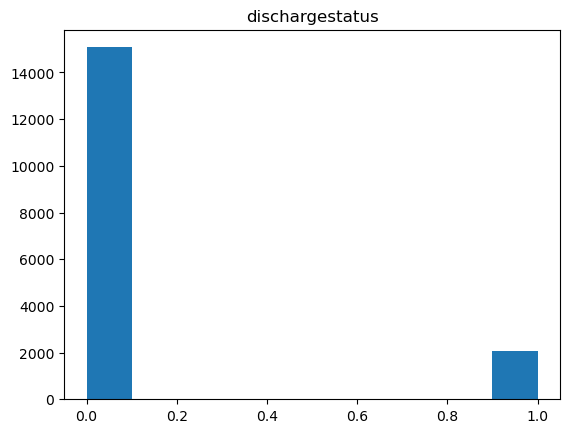

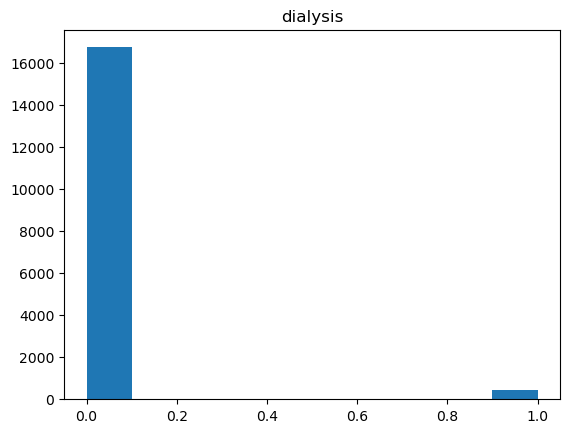

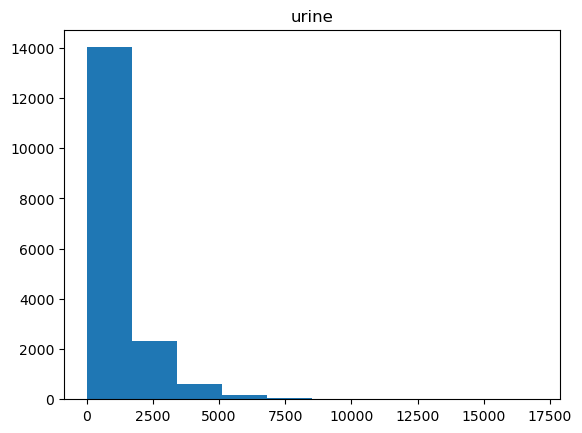

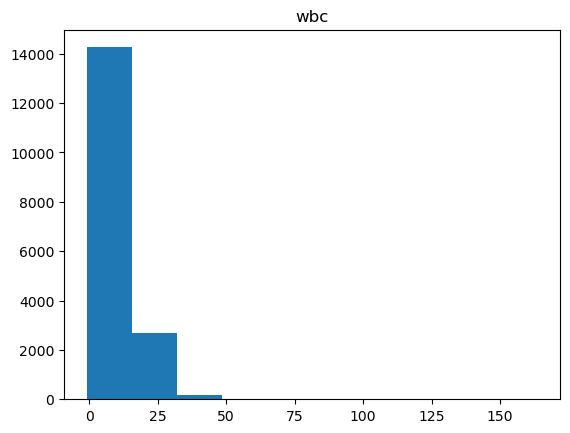

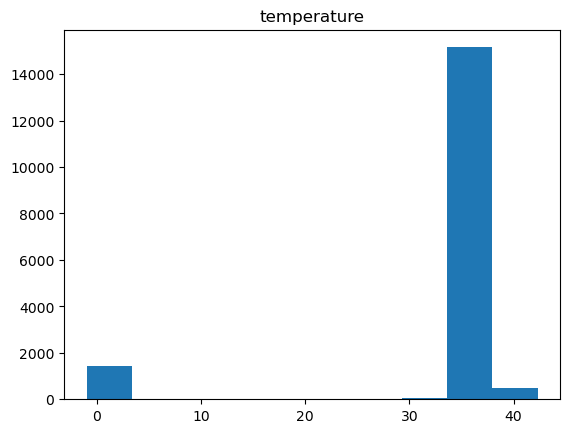

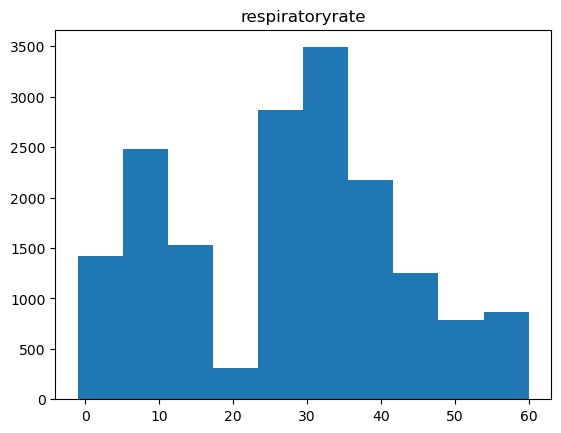

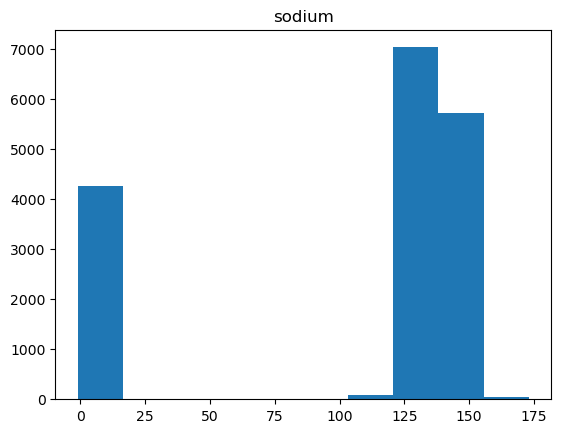

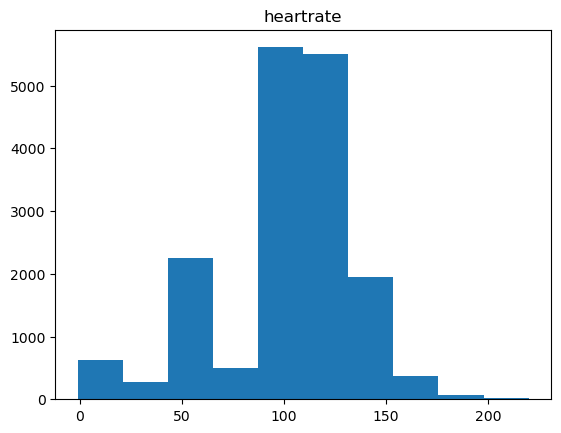

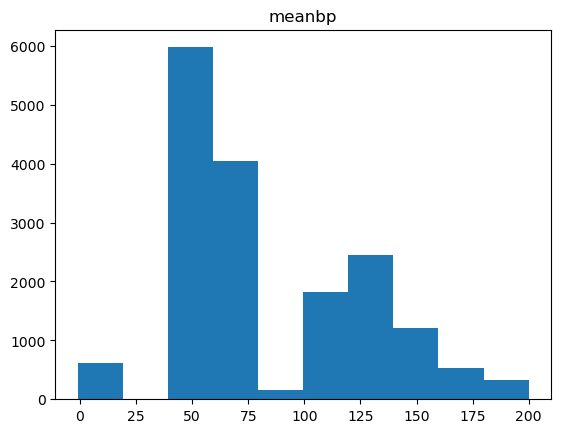

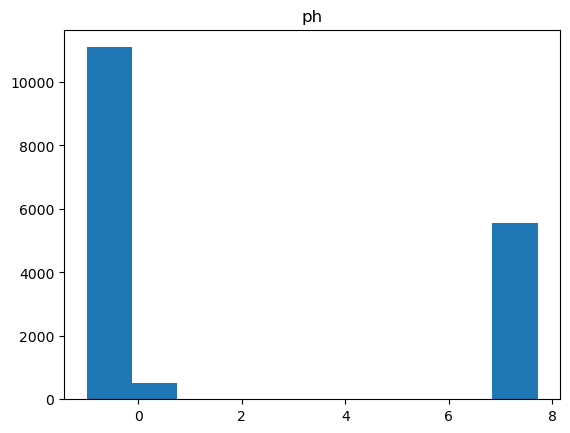

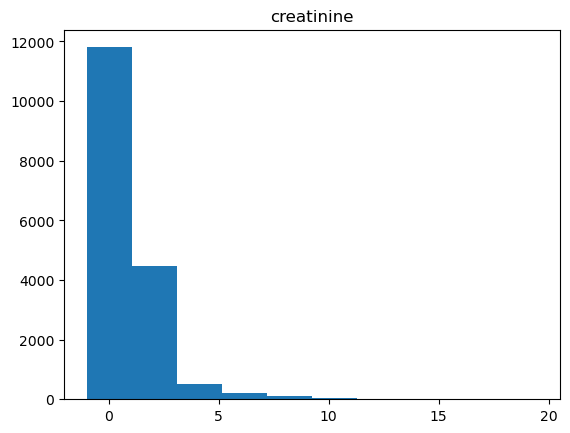

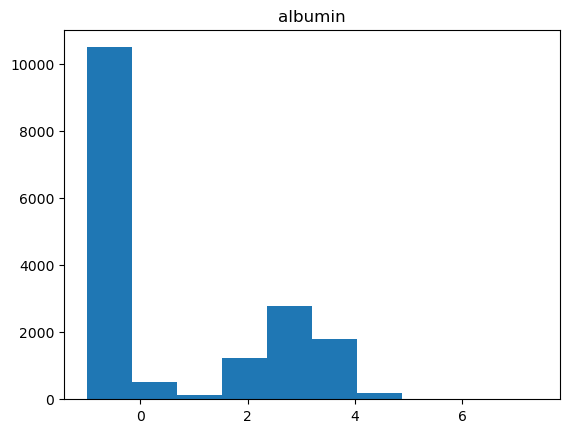

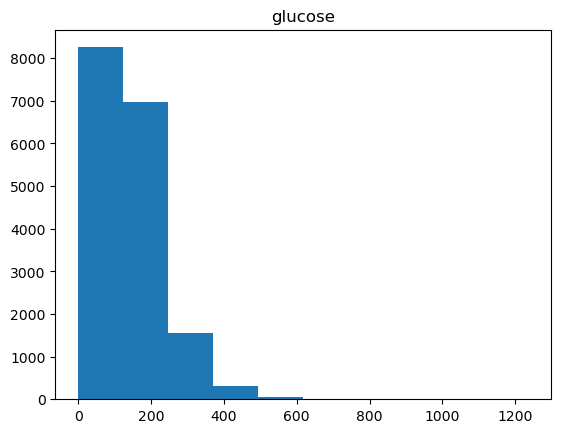

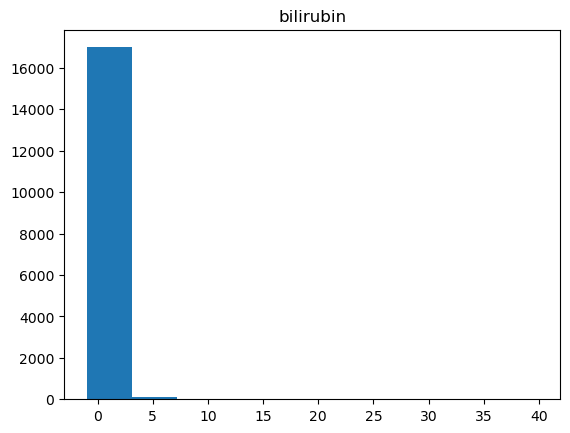

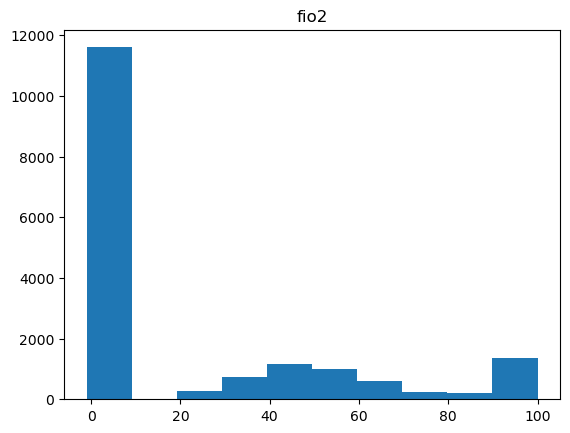

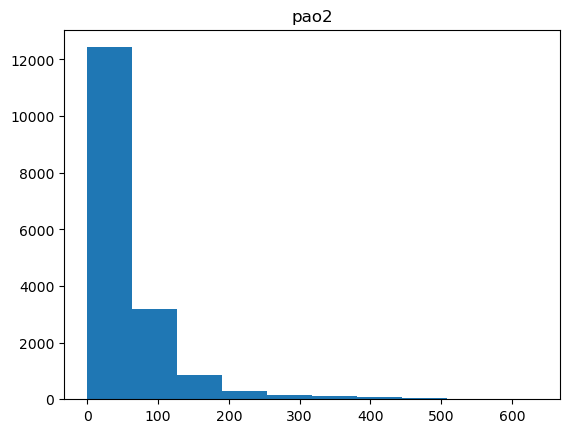

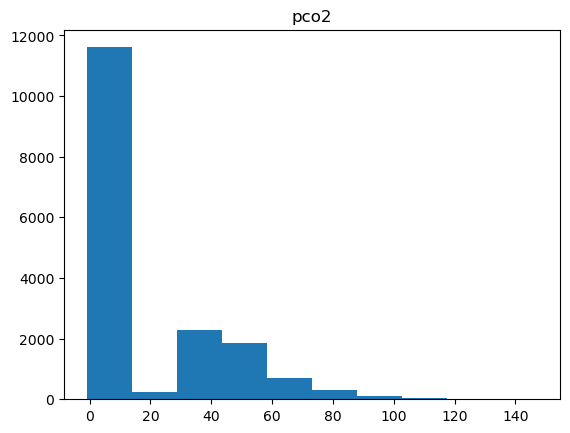

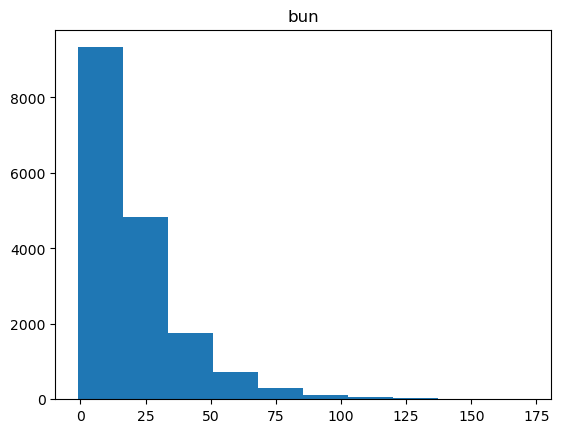

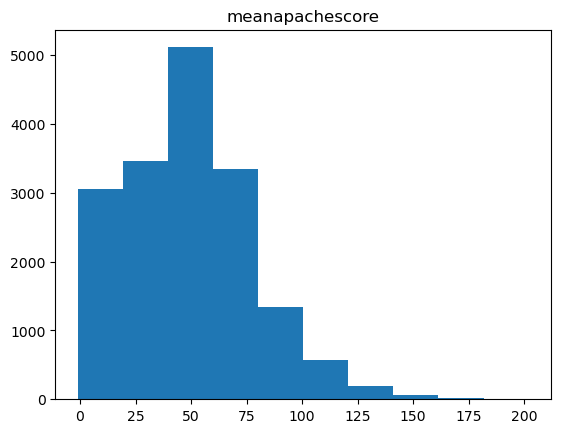

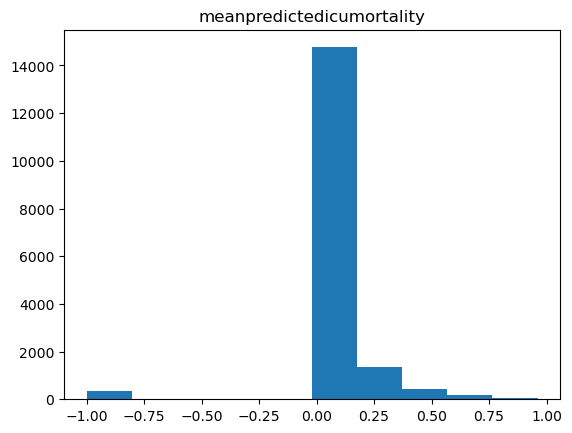

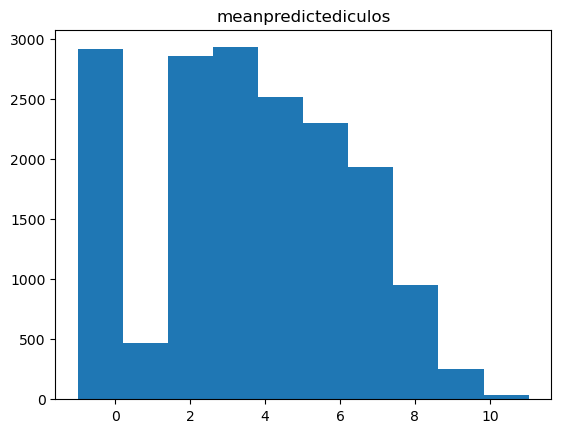

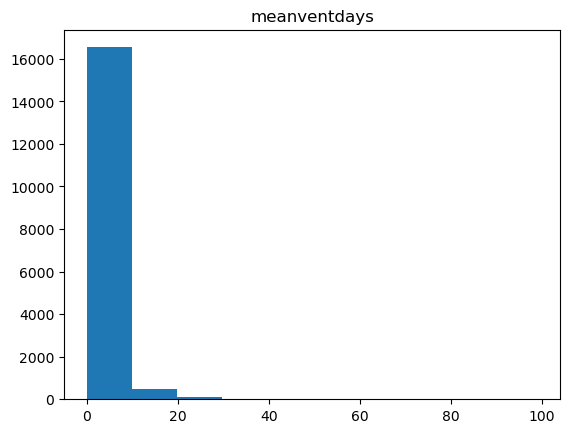

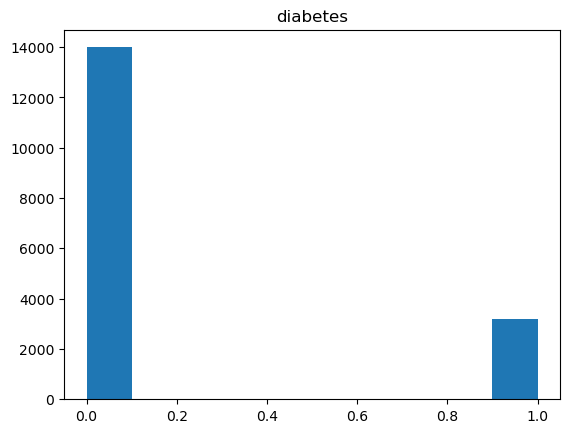

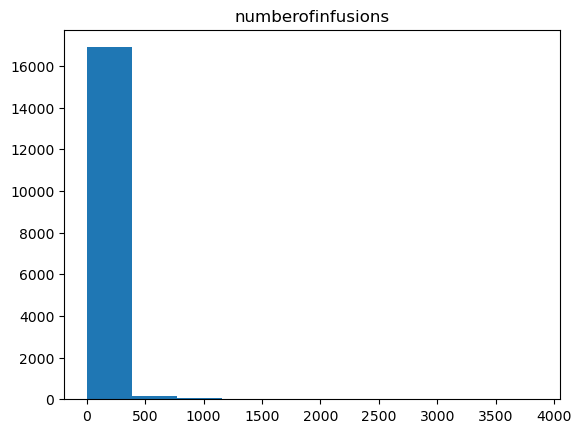

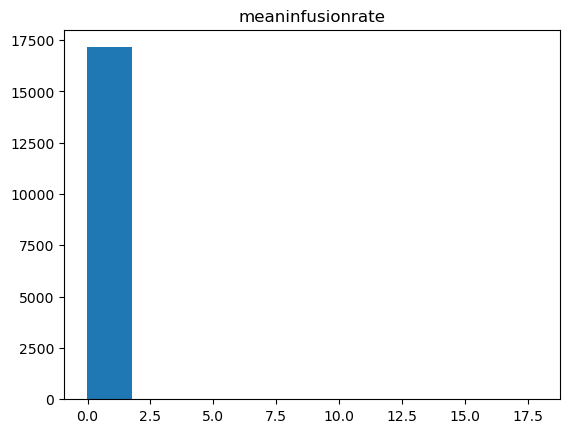

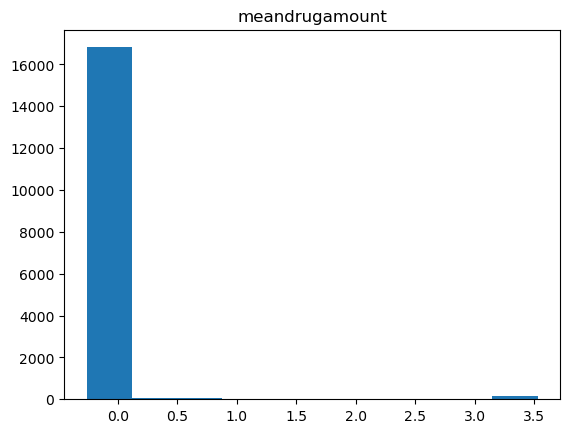

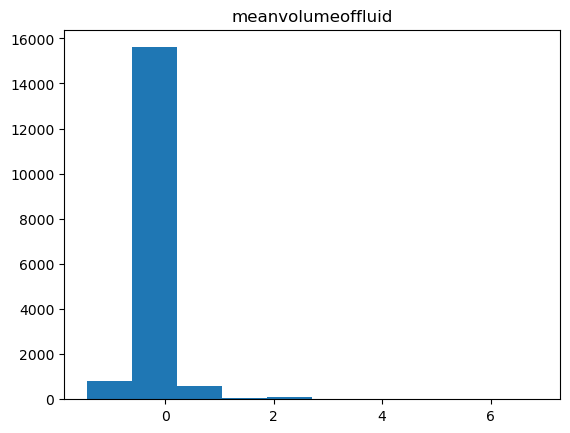

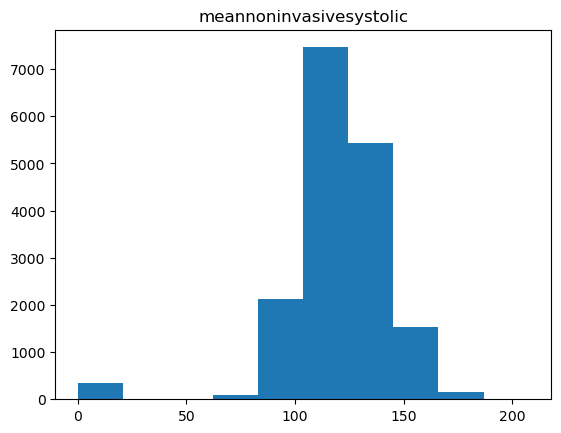

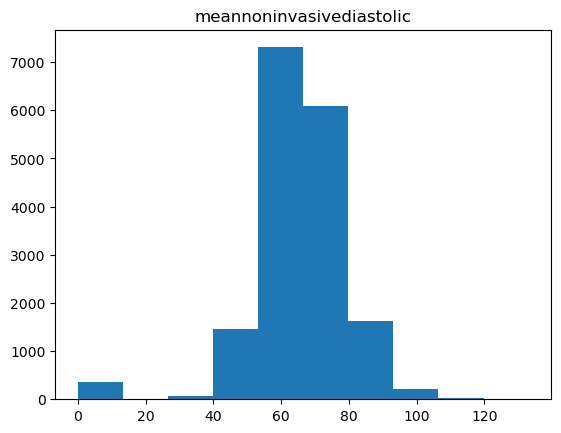

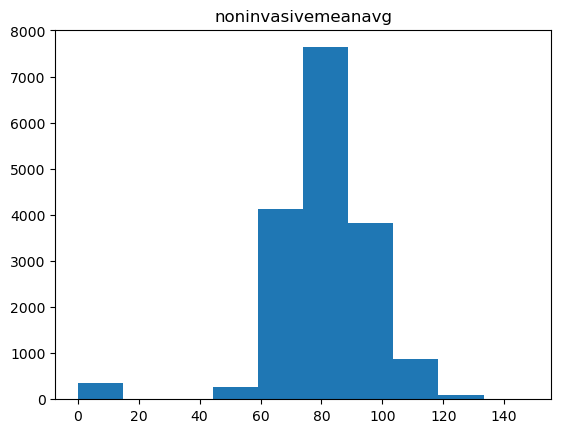

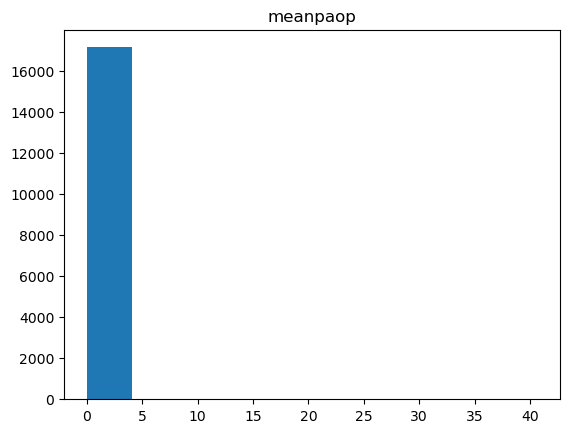

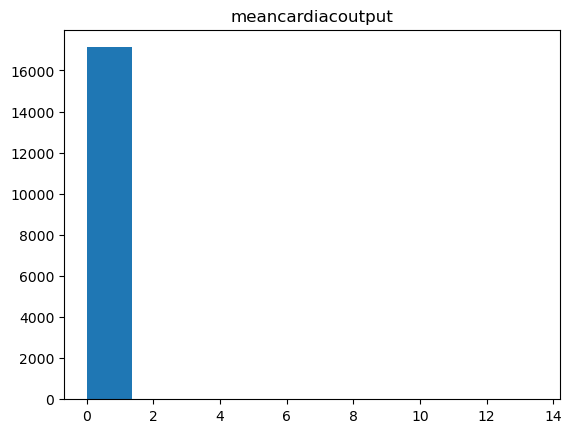

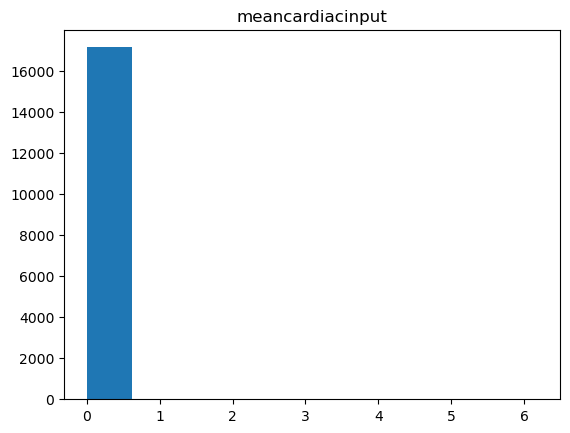

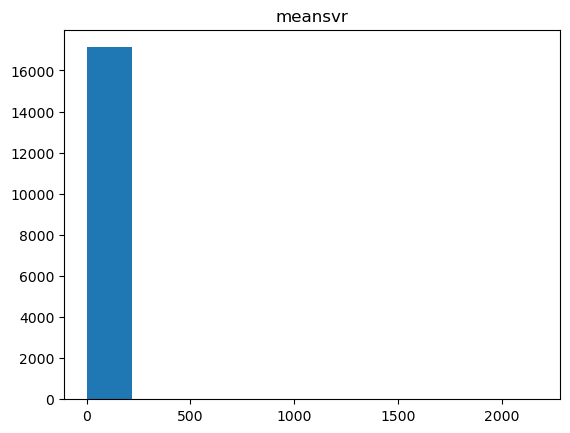

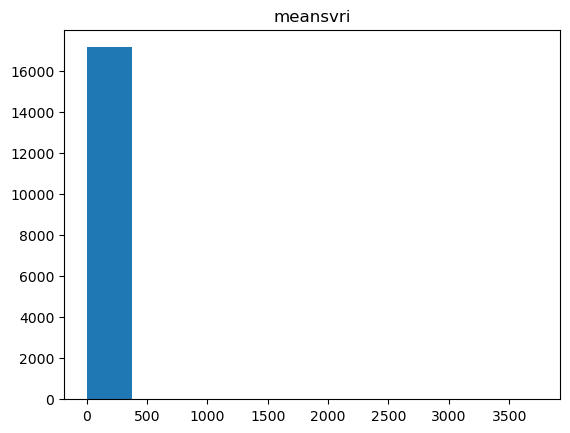

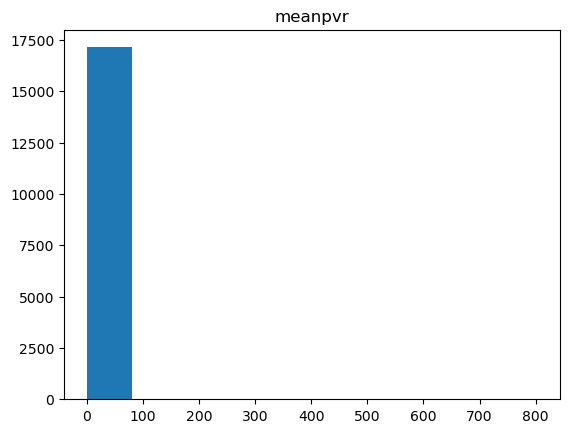

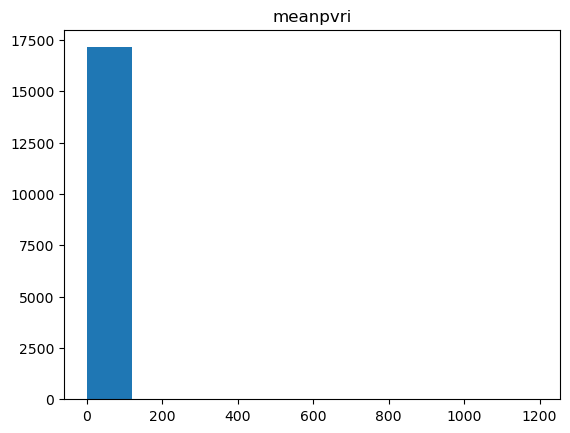

In [40]:
for n in numeric.columns:
    plt.title(n)
    plt.hist(numeric[n])
    plt.show()

In [ ]:

# ax = sns.heatmap(covmat, annot=True)


# plotting the heatmap for correlation


# data_redux = data[other_vars]
# # data_redux
# # plt.xticks(range(data_redux.select_dtypes(['number']).shape[1]), data_redux.select_dtypes(['number']).columns, fontsize=14, rotation=45)
# # plt.yticks(range(data_redux.select_dtypes(['number']).shape[1]), data_redux.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

# plt.matshow(data_redux.corr())
# plt.show()